# EDA

## 1. 데이터 전처리

1. NA값 처리 
2. 이상치 제거 

## 2. 시간 관련 변수 처리

1. 시간과 관련된 변수 --> trend 확인 불가
2. 새로운 변수 생성 --> 최종경매일 - 최초경매일 일수 차이

## 3. 카테고리 변수 처리

1. 카테고리 변수 별 y값 차이(boxplot) --> 차이가 없는 변수들 제거
2. 시군구(클러스터링 --> 더미변수)
3. 감정사(클러스터링 --> 더미변수)
4. 시도(더미변수) 

## 4. 층수 변수(안 넣어도 될 것 같기도..)

## 5. 변수 간 correlation

1. 전체 correlation plot
2. Y와의 correlation이 높으면서 서로의 correlation도 높은 6개의 변수를 선택 --> FA를 통한 차원 축소
3. Y변수와 X변수 간의 correlation --> 최저매각가격과 기존의 y를 이용해서 새로운 y변수 생성

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'
import numpy as np

In [2]:
data = pd.read_csv("Auction_master_train.csv")
data.head()

,Auction_key,Auction_class,Bid_class,Claim_price,Appraisal_company,Appraisal_date,Auction_count,Auction_miscarriage_count,Total_land_gross_area,Total_land_real_area,...,Specific,Share_auction_YorN,road_name,road_bunji1,road_bunji2,Close_date,Close_result,point.y,point.x,Hammer_price
0,2687,임의,개별,1766037301,정명감정,2017-07-26 00:00:00,2,1,12592.0,37.35,...,NaN,N,해운대해변로,30.0,NaN,2018-06-14 00:00:00,배당,35.162717,129.137048,760000000
1,2577,임의,일반,152946867,희감정,2016-09-12 00:00:00,2,1,42478.1,18.76,...,NaN,N,마린시티2로,33.0,NaN,2017-03-30 00:00:00,배당,35.156633,129.145068,971889999
2,2197,임의,개별,11326510,혜림감정,2016-11-22 00:00:00,3,2,149683.1,71.00,...,NaN,N,모라로110번길,88.0,NaN,2017-12-13 00:00:00,배당,35.184601,128.996765,93399999
3,2642,임의,일반,183581724,신라감정,2016-12-13 00:00:00,2,1,24405.0,32.98,...,NaN,N,황령대로319번가길,110.0,NaN,2017-12-27 00:00:00,배당,35.154180,129.089081,256899000
4,1958,강제,일반,45887671,나라감정,2016-03-07 00:00:00,2,1,774.0,45.18,...,NaN,N,오작로,51.0,NaN,2016-10-04 00:00:00,배당,35.099630,128.998874,158660000


In [3]:
data.shape

(1933, 41)

## 1. 데이터 전처리

### 1) NA값 처리

In [4]:
data.isna().sum()

Auction_key                       0
Auction_class                     0
Bid_class                         0
Claim_price                       0
Appraisal_company                 0
Appraisal_date                    0
Auction_count                     0
Auction_miscarriage_count         0
Total_land_gross_area             0
Total_land_real_area              0
Total_land_auction_area           0
Total_building_area               0
Total_building_auction_area       0
Total_appraisal_price             0
Minimum_sales_price               0
First_auction_date                0
Final_auction_date                0
Final_result                      0
Creditor                          0
addr_do                           0
addr_si                           0
addr_dong                         0
addr_li                        1910
addr_san                          0
addr_bunji1                       4
addr_bunji2                    1044
addr_etc                          0
Apartment_usage             

In [5]:
data = data.drop(['addr_li','addr_bunji2','Specific','road_bunji2'],axis=1)

### 2) 날짜 관련 변수

- 최초 경매일, 최종 경매일

In [6]:
from datetime import datetime
data['First_auction_date'] = data['First_auction_date'].apply(lambda x : datetime.strptime(x.split(' ')[0],"%Y-%m-%d"))
data['Final_auction_date'] = data['Final_auction_date'].apply(lambda x : datetime.strptime(x.split(' ')[0],"%Y-%m-%d"))

In [7]:
data['Final-First_auction_data'] = data['Final_auction_date']-data['First_auction_date'] #최종경매일, 최초경매일 일수 차이
data['Final-First_auction_data'] = data['Final-First_auction_data'].astype('timedelta64[D]').astype(int)

In [8]:
data = data.drop(['Final_auction_date','First_auction_date','Appraisal_date'],axis=1) #감정일자는 중요한 변수가 아닌 것 같아서 drop

### 3) 이상치제거

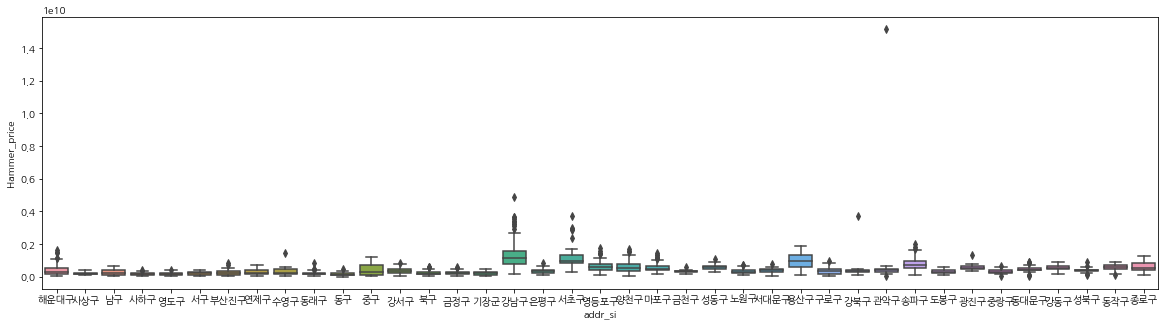

In [9]:
figure,ax1 = plt.subplots()
figure.set_size_inches(20,5)

sns.boxplot(x='addr_si',y='Hammer_price',data=data)

In [10]:
def outlier(data):
    q1, q3 = np.percentile(data,[25,75])
    iqr = q3-q1
    lb = q1 - (iqr*1.5)
    ub = q3 + (iqr*1.5)
    
    return np.where((data>ub)|(data<lb))

In [11]:
tmp = data['addr_si'].unique()
data = data.reset_index()

In [12]:
d = []
for i in tmp:
    ind = outlier(data[data['addr_si']==i]['Hammer_price'])
    ind2 = list(data[data['addr_si']==i].iloc[ind[0],:]['index'])
    if len(ind2) != 0 :
        d = d+ind2

In [13]:
data = data.drop(index=d)

## 2. 카테고리 변수 처리

### 1) addr_si - 시군구

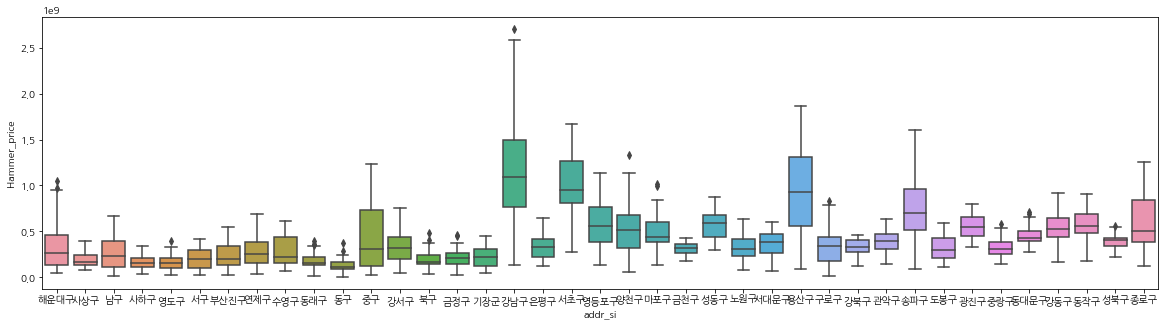

In [14]:
figure,ax1 = plt.subplots()
figure.set_size_inches(20,5)

sns.boxplot(x='addr_si',y='Hammer_price',data=data)

- 각 시군구의 y값에 대한 min q1 q2 q3 max 값을 기준으로 clustering 해서 새롭게 카테고리 생성하자

In [15]:
def get_quantile(data):
    q1, q2, q3 = np.percentile(data,[25,50,75])
    return [min(data),q1,q2,q3,max(data)]

In [16]:
df = pd.DataFrame(columns=['min','q1','q2','q3','max'])
for i in tmp:
    price = data[data['addr_si']==i]['Hammer_price']
    df = df.append(pd.Series(get_quantile(price),index=df.columns),ignore_index=True)

In [17]:
df['addr_si'] = tmp

In [18]:
df.head()

,min,q1,q2,q3,max,addr_si
0,41000000.0,127531630.0,258195000.0,458217252.5,1.050000e+09,해운대구
1,72220000.0,133355000.0,162790055.0,244747750.0,3.975000e+08,사상구
2,12760000.0,114012500.0,224556099.5,397950000.0,6.671200e+08,남구
3,31888000.0,109650492.5,151500000.0,204894250.0,3.427500e+08,사하구
4,22000000.0,103387000.0,153650550.0,210496050.0,3.940000e+08,영도구


In [19]:
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from matplotlib import pyplot as plt

- 클러스터 간 모든 점 사이 거리의 평균값 사용

In [20]:
cluster = linkage(df.iloc[:,:-1],method='average')

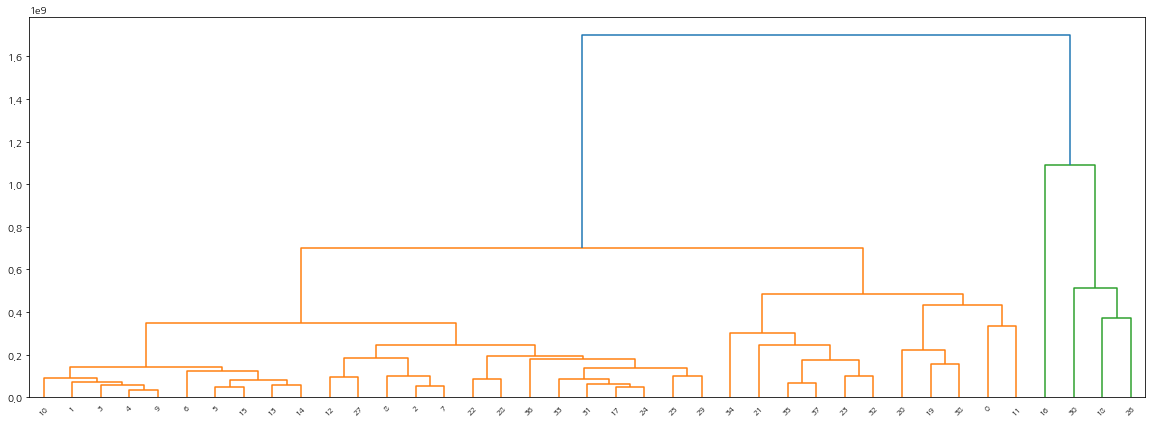

In [21]:
plt.figure(figsize=(20,7))
dent = shc.dendrogram(cluster)

In [22]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=4, linkage='average') 
pred = cluster.fit_predict(df.iloc[:,:-1])

In [23]:
df['addr_si_cluster'] = pred

- 그룹1 : 서초구 용산구 송파구
- 그룹2 : 해운대구 중구 영등포구 양천구 마포구 성동구 광진구 동대문구 강동구 동작구 종로구 
- 그룹3 : 강남구
- 그룹4 : 사상구 남구 사하구 영도구 서구 부산진구 연제구 수영구 동래구 동구 강서구 북구 금정구 기장군 은평구 금천구 노원구 서대문구 구로구 강북구 관악구 도봉구 중랑구 성북구

In [24]:
data = pd.merge(data,df[['addr_si','addr_si_cluster']],how='left',on ='addr_si')

더미변수 생성

In [25]:
data = data.join(pd.get_dummies(data['addr_si_cluster'],prefix='ad_si'))

### 2) Appraisal_company - 감정사

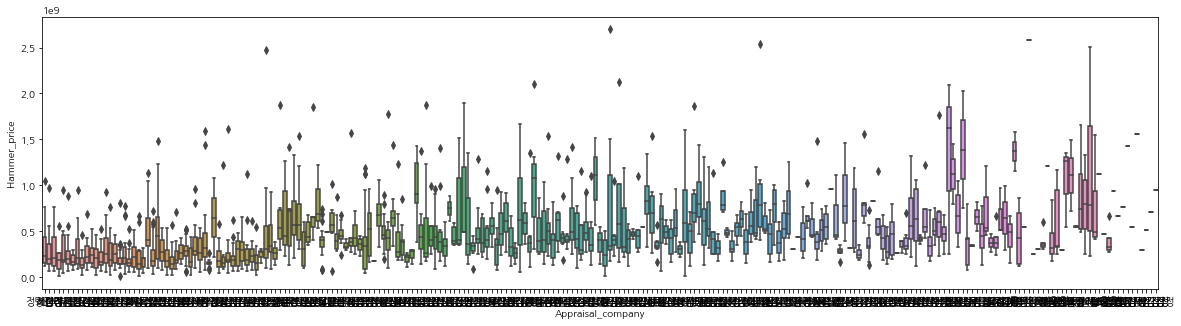

In [26]:
figure,ax1 = plt.subplots()
figure.set_size_inches(20,5)

sns.boxplot(x='Appraisal_company',y='Hammer_price',data=data)

In [27]:
tmp = data['Appraisal_company'].unique()

In [28]:
df = pd.DataFrame(columns=['min','q1','q2','q3','max'])
for i in tmp:
    price = data[data['Appraisal_company']==i]['Hammer_price']
    df = df.append(pd.Series(get_quantile(price),index=df.columns),ignore_index=True)

In [29]:
df['Appraisal_company'] = tmp

In [30]:
df.head()

,min,q1,q2,q3,max,Appraisal_company
0,118000000.0,145949742.5,227133000.0,4.330840e+08,1.050000e+09,정명감정
1,65500000.0,136901000.0,192398500.0,3.625278e+08,9.718900e+08,희감정
2,68130000.0,114231025.0,203069450.0,4.333752e+08,7.630000e+08,혜림감정
3,12760000.0,89649975.0,182799950.0,2.568242e+08,5.504000e+08,신라감정
4,37777000.0,162889250.0,185600500.0,4.608890e+08,9.500000e+08,나라감정


In [31]:
cluster = linkage(df.iloc[:,:-1],method='average')

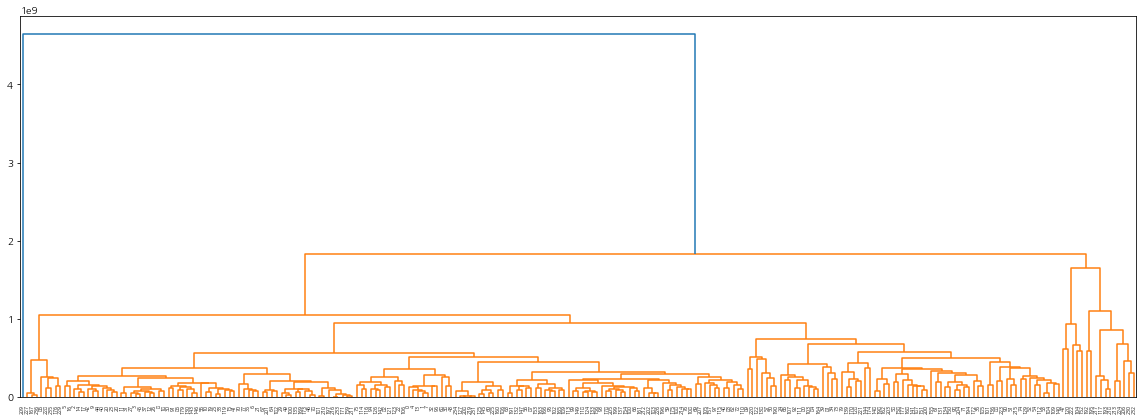

In [32]:
plt.figure(figsize=(20,7))
dent = shc.dendrogram(cluster)

3개의 군집으로 클러스터 하자!

In [33]:
cluster = AgglomerativeClustering(n_clusters=3, linkage='average')
pred = cluster.fit_predict(df.iloc[:,:-1])

In [34]:
df['Appraisal_company_cluster'] = pred

In [35]:
data = pd.merge(data,df[['Appraisal_company','Appraisal_company_cluster']],how='left',on ='Appraisal_company')

더미변수 생성

In [36]:
data = data.join(pd.get_dummies(data['Appraisal_company_cluster'],prefix='Appr'))

### 3) addr_do - 시도

In [37]:
data = data.join(pd.get_dummies(data['addr_do']))

In [38]:
data.head()

,index,Auction_key,Auction_class,Bid_class,Claim_price,Appraisal_company,Auction_count,Auction_miscarriage_count,Total_land_gross_area,Total_land_real_area,...,ad_si_0,ad_si_1,ad_si_2,ad_si_3,Appraisal_company_cluster,Appr_0,Appr_1,Appr_2,부산,서울
0,0,2687,임의,개별,1766037301,정명감정,2,1,12592.0,37.35,...,0,1,0,0,2,0,0,1,1,0
1,1,2577,임의,일반,152946867,희감정,2,1,42478.1,18.76,...,0,1,0,0,2,0,0,1,1,0
2,2,2197,임의,개별,11326510,혜림감정,3,2,149683.1,71.00,...,0,0,0,1,2,0,0,1,1,0
3,3,2642,임의,일반,183581724,신라감정,2,1,24405.0,32.98,...,0,0,0,1,2,0,0,1,1,0
4,4,1958,강제,일반,45887671,나라감정,2,1,774.0,45.18,...,0,0,0,1,2,0,0,1,1,0


## 2. Feature selecting + Y값 변환

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


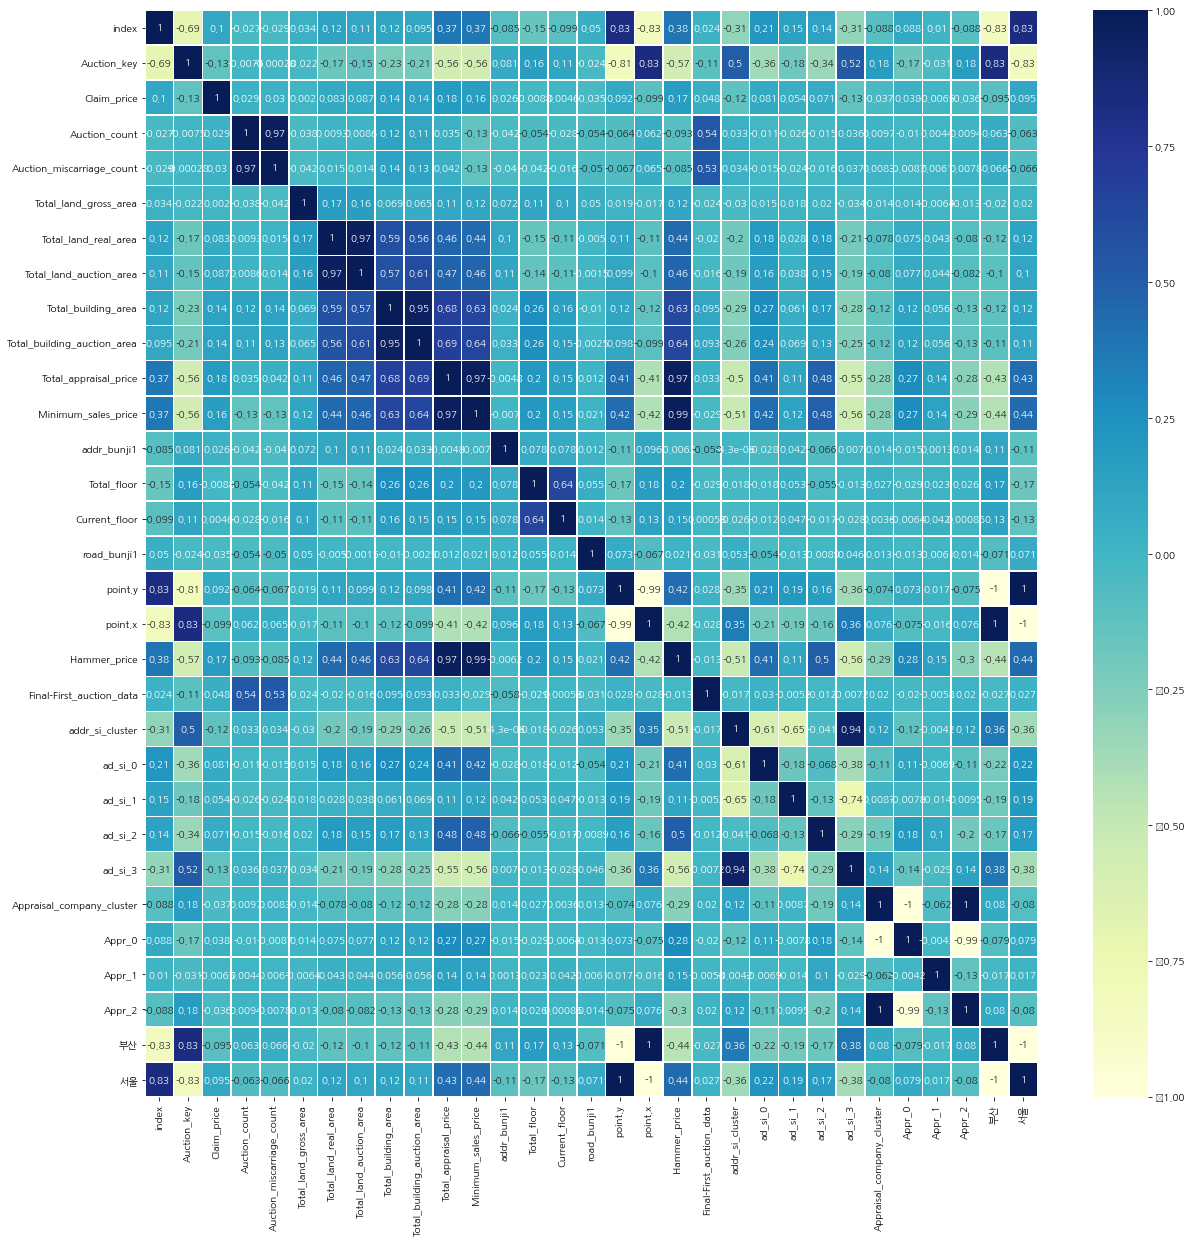

In [39]:
figure,ax1 = plt.subplots()
figure.set_size_inches(20,20)
sns.heatmap(data.corr(),linewidths=0.5,annot=True,cmap='YlGnBu')

In [40]:
data.corr()['Hammer_price']

index                          0.377009
Auction_key                   -0.567600
Claim_price                    0.171794
Auction_count                 -0.092586
Auction_miscarriage_count     -0.085099
Total_land_gross_area          0.116462
Total_land_real_area           0.442568
Total_land_auction_area        0.457792
Total_building_area            0.628985
Total_building_auction_area    0.637609
Total_appraisal_price          0.974735
Minimum_sales_price            0.989284
addr_bunji1                   -0.006176
Total_floor                    0.196538
Current_floor                  0.146635
road_bunji1                    0.020693
point.y                        0.424779
point.x                       -0.423866
Hammer_price                   1.000000
Final-First_auction_data      -0.013486
addr_si_cluster               -0.508907
ad_si_0                        0.414091
ad_si_1                        0.113341
ad_si_2                        0.498634
ad_si_3                       -0.556854


- 최저매각가격(입찰 시 입찰인이 최저로 제시해야 하는 금액) 변수와 y변수인 Hammer_price의 상관관계가 0.99
- y값 자체를 hammer_price/Minimum_sales_price 로 변환하자
- Total_appraisal_price 총감정가 변수 제거

In [41]:
data['new_y'] = data['Hammer_price']/data['Minimum_sales_price']